In [1]:
from pathlib import Path

import numpy as np
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from torch import Tensor

from src.common.log import logger
from src.common.paths import PlotPaths
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import TotalEmissionsCompressedSensingExperiment
from src.inverse_problems.footprints.gaussian_plume_model import GaussianPlumeModel
from src.inverse_problems.inverse_problems_solver import (
    SparsityTransform,
    BasisPursuitSolver,
    SparseGenerativeModelSolver,
    LeastSquaresSolver,
)
from src.models.common.metrics import ssim, relative_error
from src.plotting.city_emission_field_plot import plot_emission_field_tensor

# Gaussian Plume Simulation

In [2]:
sensor_locations = [
    (4, 5),
    (25, 6),
    (5, 26),
    (26, 25),
    (14, 15),
    (6, 15),
    (14, 5),
    (24, 15),
    (15, 27),
    (10, 9),
    (11, 20),
    (21, 10),
    (19, 21),
]

measurements_per_sensor = 50

In [3]:
model = GaussianPlumeModel()

footprints = []

for sensor_x, sensor_y in sensor_locations:
    footprints += model.get_sensitivities_for_sensor(sensor_x, sensor_y, num_measurements=measurements_per_sensor)

In [4]:
sensing_matrix = np.zeros((len(footprints), 32 * 32))
for i, footprint in enumerate(footprints):
    sensing_matrix[i, :] = footprint.reshape(32 * 32)

vmax = sensing_matrix.max()

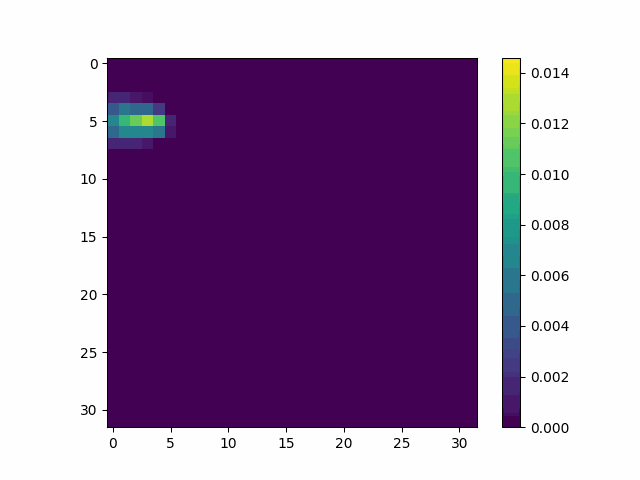

In [5]:
gif_path = Path("generated_animations") / "gaussian_plume.gif"

fig, ax = plt.subplots()

image = ax.imshow(sensing_matrix[0].reshape(32, 32), vmin=0, vmax=vmax)

plt.colorbar(image)

def update(frame):
    image.set_array(sensing_matrix[frame].reshape(32, 32))
    return [image]

ani = FuncAnimation(fig, update, frames=len(sensing_matrix), blit=True, interval=100)

plt.close()

ani.save(gif_path, writer="pillow", fps=30)

Image(filename=gif_path)

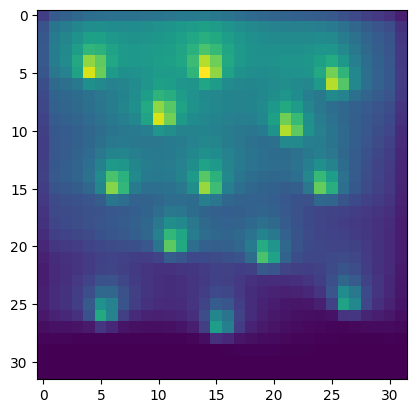

In [6]:
_, ax = plt.subplots()
ax.imshow(sensing_matrix.sum(axis=0).reshape(32, 32))

# Compressed Sensing

In [7]:
dataset_collection = TnoDatasetCollection()

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                           
	Győr, Duisburg, Szczecin, Aachen, Prague, Innsbruck, Reims, Dresden, Magdeburg, Hamburg, Großzschocher, Siegen, Gdynia
[INFO] > Validation Set has 15 unique cites!
	Brussels, Bielefeld, Koblenz, Bydgoszcz, Linz, Southampton, Wałbrzych, Ingolstadt, Zielona Góra, Kalisz, Nijmegen, Kassel, Frankfurt am Main, Angers, Erfurt
[INFO] > Training Set has 74 unique cites!
	Tours, Karlsruhe, Bremerhaven, Dijon, Gorzów Wielkopolski, Kingston upon Hull, Amiens, Nancy, Legnica, Nantes, Trier, London, Southend-on-Sea, Nürnberg, Leeds, Norwich, Brighton, Orléans, Poznań, Copenhagen, Le Havre, Rotterdam, Sunderland, Groningen, Brno, Kiel, Le Mans, Sa

In [8]:
CITY = "Munich"
CITY_LOWER = CITY.lower()

In [9]:
ls_solver = LeastSquaresSolver()

bp_solver = BasisPursuitSolver()
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT)

gen_256 = SparseGenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_512 = SparseGenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_1024 = SparseGenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_2048 = SparseGenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_256_fine_tuned = SparseGenerativeModelSolver.from_vae_model_name(f"256_{CITY_LOWER}", plot_loss=True)
gen_512_fine_tuned = SparseGenerativeModelSolver.from_vae_model_name(f"512_{CITY_LOWER}", plot_loss=True)
gen_1024_fine_tuned = SparseGenerativeModelSolver.from_vae_model_name(f"1024_{CITY_LOWER}", plot_loss=True)
gen_2048_fine_tuned = SparseGenerativeModelSolver.from_vae_model_name(f"2048_{CITY_LOWER}", plot_loss=True)

In [10]:
city_data = dataset_collection.get_single_case_study_city_emission_field(city=CITY, year=2018)

x_a = city_data.co2_ff_area_sources_tensor.sum(0)

In [11]:
vmax = 1.1 * float(x_a.max())

plot_dir = PlotPaths.PLOTS / "gaussian_plume_example" / CITY_LOWER
plot_dir.mkdir(exist_ok=True, parents=True)

# Target

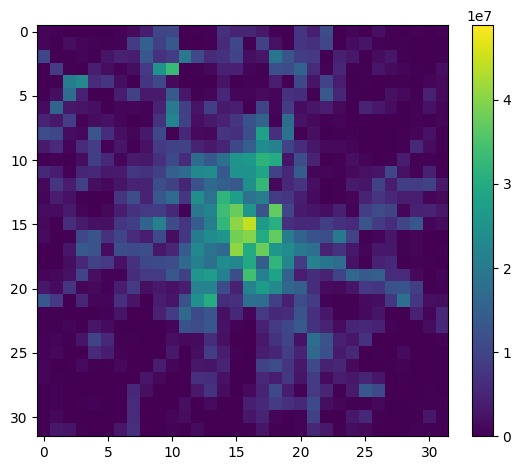

In [12]:
_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_a, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / "target.eps", format="eps", bbox_inches="tight")

# Low Noise Scenario

In [14]:
snr_db = 20
snr = 10 ** (snr_db / 10)

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x_a,
    Tensor(sensing_matrix),
    snr=snr
)

## Least Squares

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-01
[INFO] > SSIM=0.449
[INFO] > Relative Error=49.767%


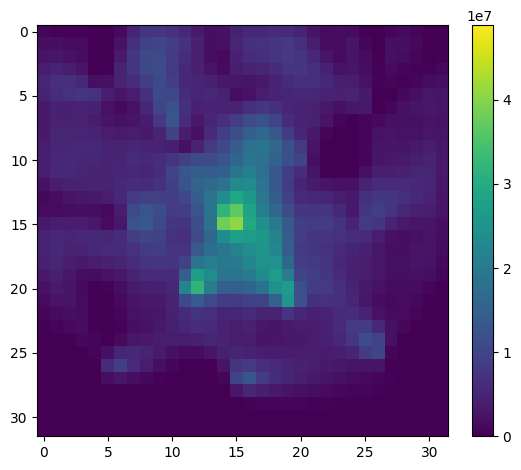

In [15]:
x_rec_ls = problem.solve(ls_solver)

logger.info(f"SSIM={ssim(x_a, x_rec_ls):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_ls):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_ls, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"least_squares_snr_{snr_db}_db.eps", format="eps", bbox_inches="tight")

## Basis Pursuit Denoising Discrete Wavelet Transform

[INFO] > SSIM=0.445
[INFO] > Relative Error=51.102%


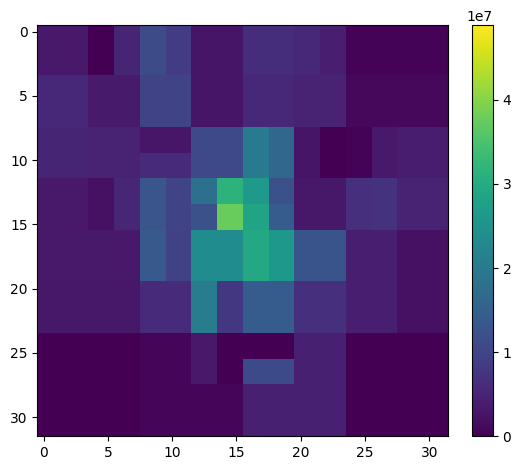

In [16]:
x_rec_dwt = problem.solve(bp_solver_dwt)

logger.info(f"SSIM={ssim(x_a, x_rec_dwt):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_dwt):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_dwt, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"bp_dwt_snr_{snr_db}_db.eps", format="eps", bbox_inches="tight")

## Basis Pursuit Denoising Discrete Cosine Transform

[INFO] > SSIM=0.514
[INFO] > Relative Error=47.767%


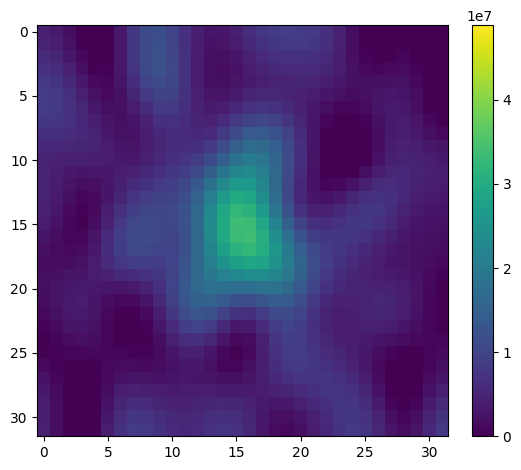

In [17]:
x_rec_dct = problem.solve(bp_solver_dct)

logger.info(f"SSIM={ssim(x_a, x_rec_dct):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_dct):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_dct, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"bp_dct_snr_{snr_db}_db.eps", format="eps", bbox_inches="tight")

## Generative Model Solver

[INFO] > SSIM=0.426
[INFO] > Relative Error=54.880%


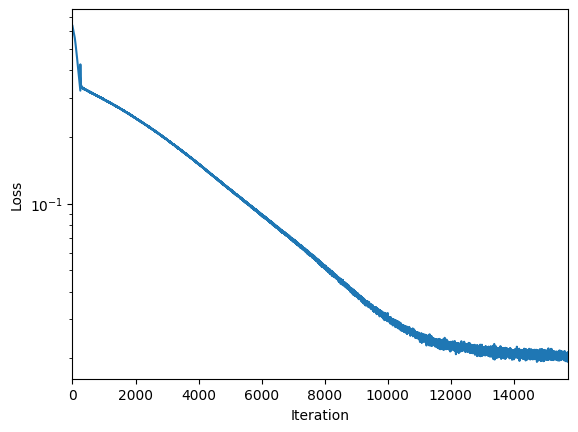

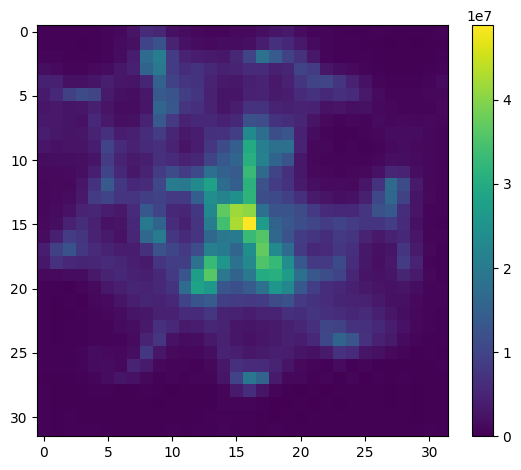

In [31]:
x_rec_gen_256 = problem.solve(gen_256, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_256):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_256):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_256, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_256_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.499
[INFO] > Relative Error=50.999%


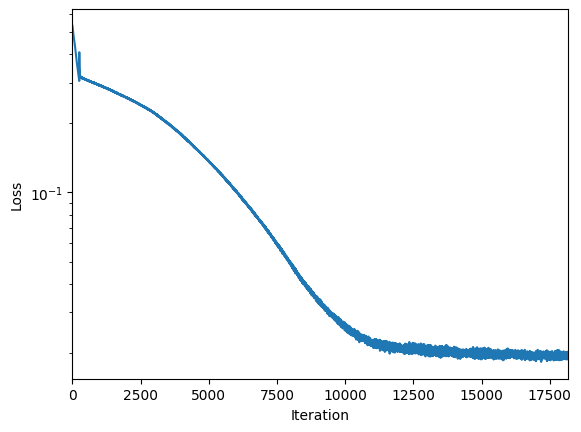

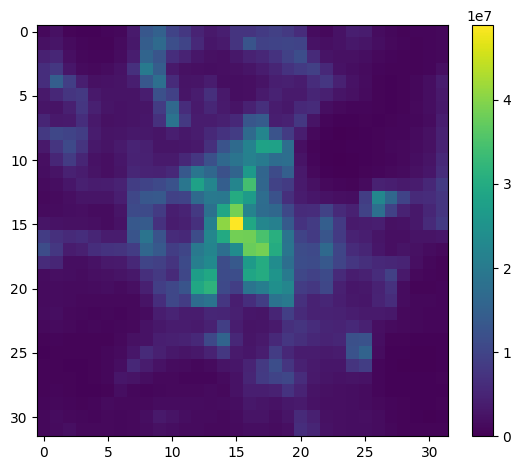

In [32]:
x_rec_gen_512 = problem.solve(gen_512, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_512):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_512):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_512, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_512_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.493
[INFO] > Relative Error=48.941%


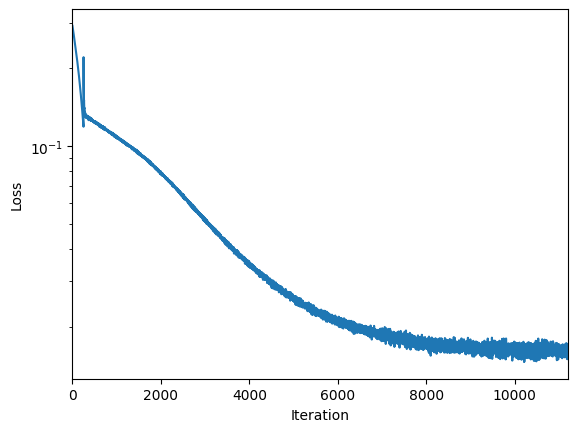

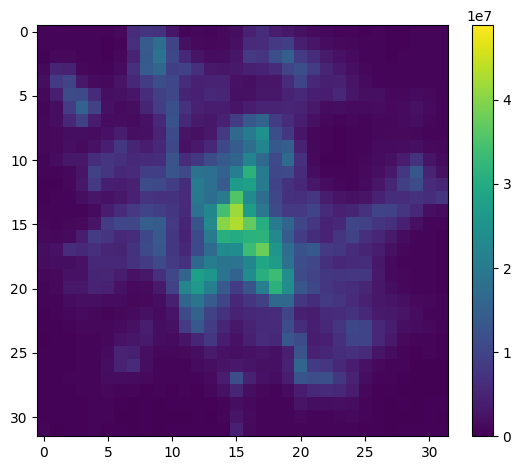

In [28]:
x_rec_gen_1024 = problem.solve(gen_1024, lambda_=5e-4)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_1024):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_1024):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_1024, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_1024_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.520
[INFO] > Relative Error=46.139%


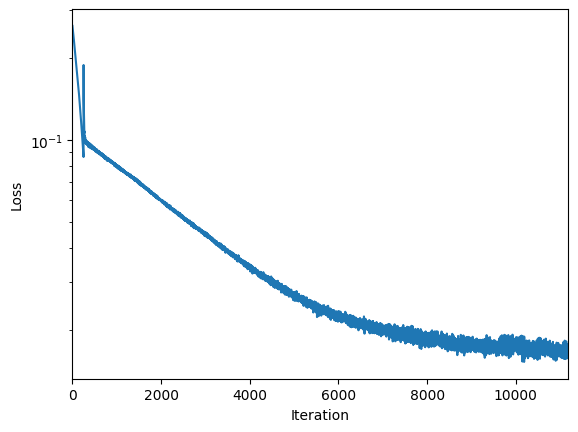

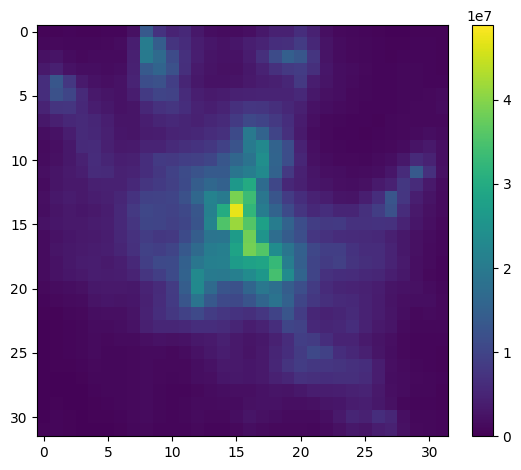

In [27]:
x_rec_gen_2048 = problem.solve(gen_2048, lambda_=5e-4)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_2048):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_2048):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_2048, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_2048_{snr_db}_db.eps", format="eps", bbox_inches="tight")

## Fine-tuned Generative Model Solver

[INFO] > SSIM=0.585
[INFO] > Relative Error=46.333%


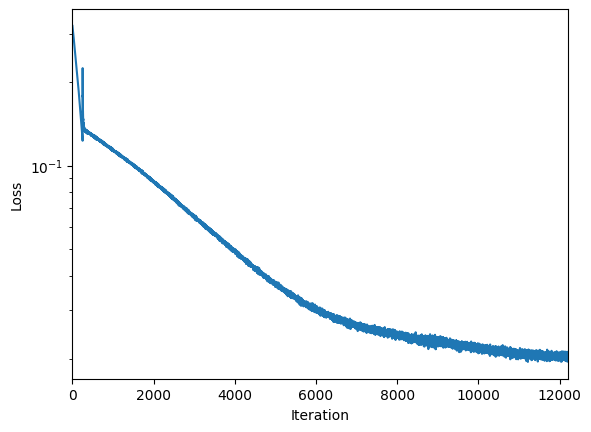

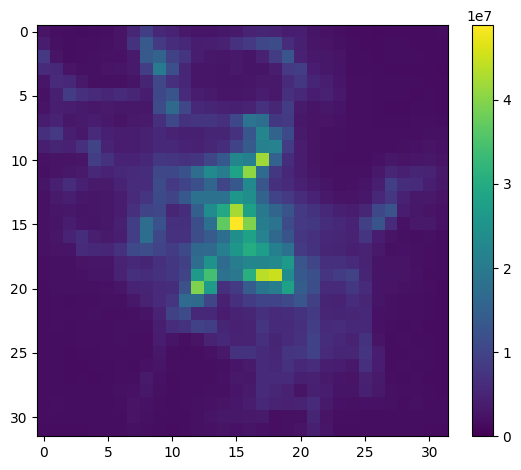

In [34]:
x_rec_gen_256_fine_tuned = problem.solve(gen_256_fine_tuned, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_256_fine_tuned):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_256_fine_tuned):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_256_fine_tuned, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_256_fine_tuned_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.710
[INFO] > Relative Error=35.974%


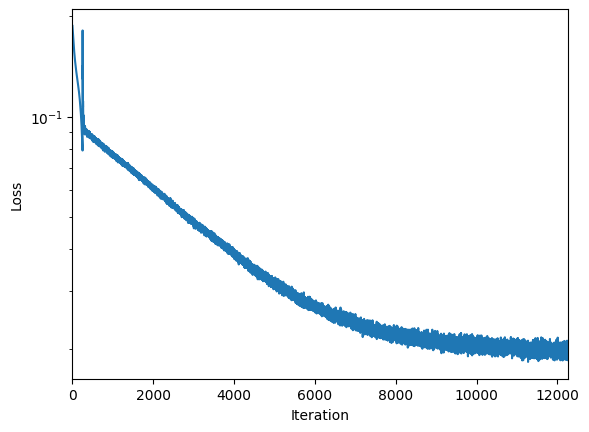

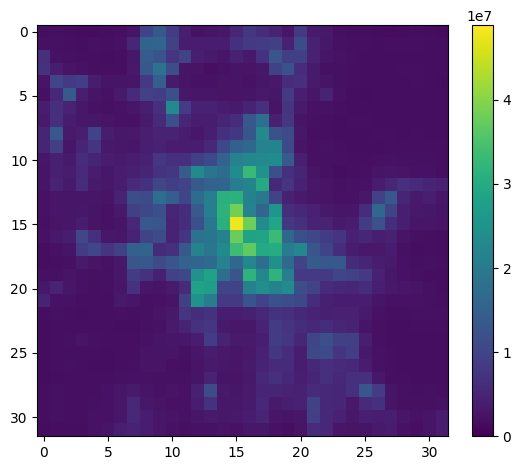

In [38]:
x_rec_gen_512_fine_tuned = problem.solve(gen_512_fine_tuned, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_512_fine_tuned):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_512_fine_tuned):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_512_fine_tuned, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_512_fine_tuned_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.739
[INFO] > Relative Error=37.609%


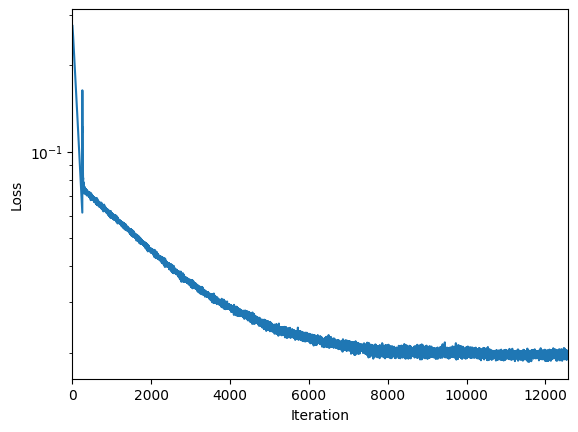

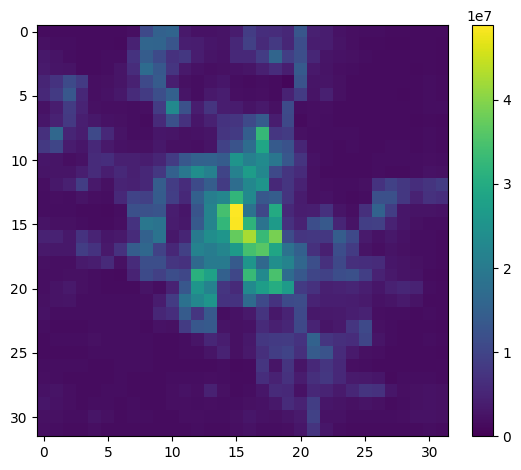

In [40]:
x_rec_gen_1024_fine_tuned = problem.solve(gen_1024_fine_tuned, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_1024_fine_tuned):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_1024_fine_tuned):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_1024_fine_tuned, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_1024_fine_tuned_{snr_db}_db.eps", format="eps", bbox_inches="tight")

[INFO] > SSIM=0.751
[INFO] > Relative Error=32.833%


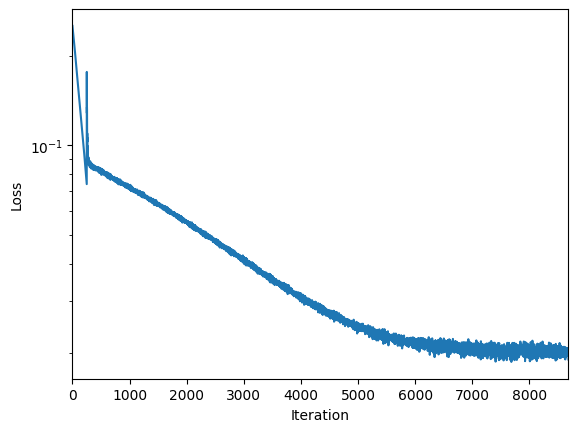

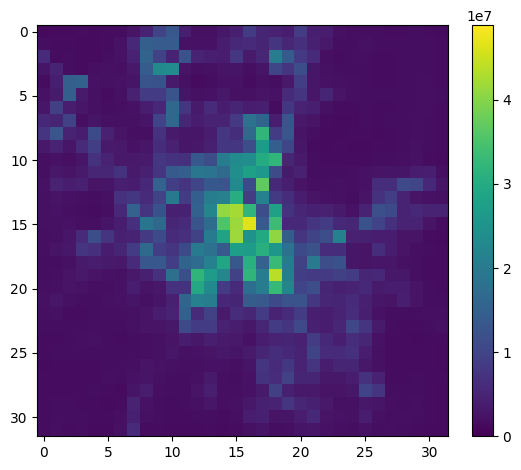

In [41]:
x_rec_gen_2048_fine_tuned = problem.solve(gen_2048_fine_tuned, lambda_=1e-3)

logger.info(f"SSIM={ssim(x_a, x_rec_gen_2048_fine_tuned):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec_gen_2048_fine_tuned):.3f}%")

_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_gen_2048_fine_tuned, vmax=vmax)

plt.tight_layout()
plt.savefig(plot_dir / f"gen_2048_fine_tuned_{snr_db}_db.eps", format="eps", bbox_inches="tight")